In [25]:
# Importing libraries
import scipy
import numpy as np
import keras.utils
import tensorflow as tf
import torch
from torch.optim import SGD
import time
from LeNet5_NEW import LeNet5
import os

# Retrieving data
PATH = os.path.join(os.getcwd(), "matlab", "emnist-letters.mat")
EMNIST = scipy.io.loadmat(PATH)
x_train = EMNIST["dataset"][0][0][0][0][0][0].astype("float64")
y_train = EMNIST["dataset"][0][0][0][0][0][1]

x_test = EMNIST['dataset'][0][0][1][0][0][0].astype("float64")
y_test = EMNIST['dataset'][0][0][1][0][0][1]

# Filter out lowercase letters (class labels 1 to 26)
lowercase_indices_train = np.where((y_train >= 1) & (y_train <= 26))[0]
lowercase_indices_test = np.where((y_test >= 1) & (y_test <= 26))[0]

x_train = x_train[lowercase_indices_train]
y_train = y_train[lowercase_indices_train]

x_test = x_test[lowercase_indices_test]
y_test = y_test[lowercase_indices_test]

# Scaling data
x_train = (x_train - np.mean(x_train)) / np.std(x_train)
x_test = (x_test - np.mean(x_train)) / np.std(x_train)

nb_classes = 26  # Number of classes

y_train = keras.utils.to_categorical(y_train-1, nb_classes)
y_test = keras.utils.to_categorical(y_test-1, nb_classes)

x_train_scaled = x_train.reshape(-1, 28, 28, 1)
x_test_scaled = x_test.reshape(-1, 28, 28, 1)


# Padding to have 32x32 images has in the paper about LeNet5
x_train_padded = np.array(tf.pad(tensor=x_train_scaled, paddings=[[0, 0], [2, 2], [2, 2], [0, 0]]))
x_test_padded = np.array(tf.pad(tensor=x_test_scaled, paddings=[[0, 0], [2, 2], [2, 2], [0, 0]]))



# Pytorch needs a special format
x_train_tensor = torch.tensor(x_train_padded, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test_padded, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# start = time.time() # Measuring computation time

# num_epochs = 30
# batch_size = 300

# # Model of CNN
# model = LeNet5(nb_classes)
# # Loss
# criterion = torch.nn.CrossEntropyLoss()

# # Optimizer
# optimizer = SGD(model.parameters(), lr=0.05)

# # Training
# for epoch in range(num_epochs):
#     # Shuffle the data at the beginning of an epoch

#     indices = np.arange(len(x_train_tensor))
#     np.random.shuffle(indices)
#     total_correct_predictions = 0
#     total_samples = 0

#     for i in range(0, len(x_train), batch_size):
#         # Select batch by batch
#         batch_indices = indices[i:i + batch_size]
#         inputs = x_train_tensor[batch_indices].permute(0, 3, 1, 2)

    #     labels = y_train_tensor[batch_indices]

    #     #Forward propagation
    #     outputs = model(inputs)

    #     # Compute the loss
    #     loss = criterion(outputs, labels)

    #     with torch.no_grad():
    #         model.eval()
    #         _, predicted_labels = torch.max(outputs, 1)
    #         _, target_labels = torch.max(labels, 1)
    #         batch_correct_predictions = (predicted_labels == target_labels).sum().item()

    #         # Accumulate the total number of correct predictions and total samples
    #         total_correct_predictions += batch_correct_predictions
    #         total_samples += labels.size(0)
    #         model.train()

    #     # Back-propagation and optimisation
    #     optimizer.zero_grad()
    #     loss.backward()
    #     optimizer.step()

    # # Calculate accuracy at the end of the epoch
    # epoch_accuracy = total_correct_predictions / total_samples

    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_accuracy:.4f}')


In [51]:
torch.save(model, os.path.join(os.getcwd(), "model.pt" ))

In [2]:
model = torch.load(os.path.join(os.getcwd(), "model.pt"))

# Evaluation loop
inputs = x_test_tensor.permute(0, 3, 1, 2)
labels = y_test_tensor
total_correct_predictions = 0
total_samples = 0
# Forward propagation
model.eval()
outputs = model(inputs)

# Compute the loss
loss_test = criterion(outputs, labels)
# Set model to evaluation mode and evaluate it
with torch.no_grad():
    model.eval()
    _, predicted_labels = torch.max(outputs, 1)
    _, target_labels = torch.max(labels, 1)
    batch_correct_predictions = (predicted_labels == target_labels).sum().item()

# Accumulate the total number of correct predictions and total samples
total_correct_predictions += batch_correct_predictions
total_samples += labels.size(0)

accuracy_test = total_correct_predictions / total_samples

print(f'TEST : Loss: {loss_test.item():.4f}, Accuracy: {accuracy_test:.4f}')

# Affichage de quelques résultats
#for i in range(20):
#    print('Essai', i, ':\n Predicted =', predicted_labels[i], '\n Correction =', target_labels[i],'\n')




NameError: name 'torch' is not defined

In [141]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

"""
    Ce script prend une image (en format jpg) d'un mot et donne en sortie des images (en format jpg) de chaque lettre
    du mot, triées dans l'ordre imposé par le mot. La dernière image correspond au mot en lui-même et peut être oubliée.
    Le principe est le suivant :
    L'image d'entrée est mise en noir et blanc pour bien différencier les contours du fond. On identifie les contours
    et on retire tout ceux qui sont trop fins (bruit). On trie les contours, puis on rogne à chaque fois la figure selon
    la dimension du contour et on enregistre l'image.
"""

def mirror_image(image):
    # Création d'une nouvelle matrice pour l'image miroir
    mirrored_image = [[0 for _ in range(32)] for _ in range(32)]

    # Parcourir l'image d'origine et inverser l'ordre des pixels dans chaque ligne
    for i in range(32):
        # Inverser l'ordre des pixels dans la ligne
        mirrored_image[i] = image[i][::-1]

    return mirrored_image

def rotate_image_90_clockwise(image):
    # Création d'une nouvelle matrice pour l'image pivotée
    rotated_image = [[0 for _ in range(32)] for _ in range(32)]

    # Parcourir l'image d'origine et copier les pixels dans la nouvelle position
    for i in range(32):
        for j in range(32):
            # Calculer la nouvelle position du pixel
            new_i = j
            new_j = 31 - i  # Rotation de 90 degrés dans le sens des aiguilles d'une montre

            # Copier la valeur du pixel dans sa nouvelle position
            rotated_image[new_i][new_j] = image[i][j]

    return rotated_image

def resize_image(image, new_width, new_height):
    # Calculer les facteurs d'échelle en fonction des dimensions d'origine et de destination
    scale_x = new_width / 32
    scale_y = new_height / 32

    # Créer une nouvelle matrice pour l'image redimensionnée
    resized_image = [[0 for _ in range(new_width)] for _ in range(new_height)]

    # Parcourir la nouvelle matrice et interpoler les valeurs de pixel
    for i in range(new_height):
        for j in range(new_width):
            # Calculer les coordonnées correspondantes dans l'image d'origine
            original_x = int(j / scale_x)
            original_y = int(i / scale_y)

            # Copier la valeur du pixel de l'image d'origine à l'emplacement correspondant dans l'image redimensionnée
            resized_image[i][j] = image[original_y][original_x]

    return resized_image

def resize_with_padding(image, target_size):
    # Calculer les dimensions du padding
    h, w = image.shape[:2]
    ratio = min(target_size[0] / w, target_size[1] / h)
    new_w = int(w * ratio)
    new_h = int(h * ratio)
    pad_w = (target_size[0] - new_w) // 2
    pad_h = (target_size[1] - new_h) // 2

    # Ajouter le padding
    padded_image = cv2.copyMakeBorder(image, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=255)

    # Redimensionner l'image
    resized_image = cv2.resize(padded_image, target_size, interpolation=cv2.INTER_AREA)

    return resized_image

def isolate_letters(filepath):

    # Charger l'image
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    image = cv2.GaussianBlur(image, (5, 7), cv2.BORDER_DEFAULT)

    se = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
    bg = cv2.morphologyEx(image, cv2.MORPH_DILATE, se)
    out_gray = cv2.divide(image, bg, scale=255)
    out_binary = cv2.threshold(out_gray, 0, 255, cv2.THRESH_OTSU)[1]
    out_binary = cv2.bitwise_not(out_binary)

    # Afficher l'image binarisée
    # cv2.imshow('Image binarisée', out_binary)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


    # Contours detection sur l'image binarisée
    contours, _ = cv2.findContours(out_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrer les contours pour éliminer les plus petits
    contours = [contour for contour in contours if cv2.contourArea(contour) > 50]

    # Trier les contours dans l'ordre du mot
    contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])


    # Afficher les contours sur l'image
    # contour_img = cv2.drawContours(cv2.cvtColor(out_binary, cv2.COLOR_GRAY2BGR), contours, -1, (0, 255, 0), 2)
    # cv2.imshow("Contours", contour_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Segmenter les lettres
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        # Découper l'image pour obtenir la lettre

        letter = cv2.bitwise_not(out_binary[y:y + h, x:x + w])

        # Compress to 28 x 28 pixelized image
        letter = resize_with_padding(letter, (32, 32))
        
        # Rotate and inverse the image to match the mnist format
        letter = rotate_image_90_clockwise( rotate_image_90_clockwise(rotate_image_90_clockwise( mirror_image(letter))))
    
        # Dezoom
        letter = resize_image(letter, 27, 27)

        letter = cv2.bitwise_not(np.array(letter))

        letter =  np.array(tf.pad(tensor=letter, paddings=[[2, 3], [2, 3]]))
        letter = (letter - np.mean(letter))/np.std(letter)
        yield letter

In [143]:
import torch
import os

import numpy as np
from collections import Counter
import matplotlib.pyplot as plt





model = torch.load(os.path.join(os.getcwd(), "model.pt"))


filepath = os.path.join("C:/Users", "msii", "Downloads", "HelloWorld.jpg")



dict_mot ={i:[] for i in range(20)}

j = 0
for letter in isolate_letters(filepath):
    letter = np.expand_dims(letter, axis=-1)

    # Ajouter une dimension pour le batch, tranformation en torch.tensor et permutation des index
    letter = torch.tensor(np.expand_dims(letter, axis=0), dtype = torch.float32).permute(0, 3, 1, 2)

    for i in range(20):

        outputs = model(letter)
        dict_mot[i].append(chr(np.argmax(outputs.detach().numpy()[0]) + 97)) # Convertir la prédiction en lettre minuscule
        
resultat = ''.join([Counter(v).most_common(1)[0][0] for v in zip(*dict_mot.values())])
print(resultat)


filepath = os.path.join("C:/Users", "msii", "Downloads", "perruche.jpg")



dict_mot ={i:[] for i in range(20)}

j = 0
for letter in isolate_letters(filepath):
    letter = np.expand_dims(letter, axis=-1)

    # Ajouter une dimension pour le batch, tranformation en torch.tensor et permutation des index
    letter = torch.tensor(np.expand_dims(letter, axis=0), dtype = torch.float32).permute(0, 3, 1, 2)
    for i in range(20):
        outputs = model(letter)
        dict_mot[i].append(chr(np.argmax(outputs.detach().numpy()[0]) + 97)) # Convertir la prédiction en lettre minuscule
        
resultat = ''.join([Counter(v).most_common(1)[0][0] for v in zip(*dict_mot.values())])
print(resultat)

helldworld
coucoupetiteperruche


TEST : Loss: 9.6605, Accuracy: 0.9080


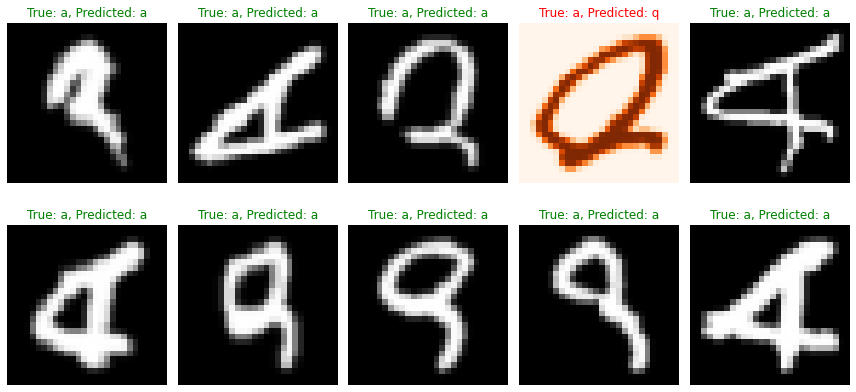

In [27]:
inputs = x_test_tensor.permute(0, 3, 1, 2)
labels = y_test_tensor
total_correct_predictions = 0
total_samples = 0
criterion = torch.nn.CrossEntropyLoss()
# Forward propagation
model.eval()
outputs = model(inputs)

# Compute the loss
loss_test = criterion(outputs, labels)
# Set model to evaluation mode and evaluate it
with torch.no_grad():
    model.eval()
    _, predicted_labels = torch.max(outputs, 1)
    _, target_labels = torch.max(labels, 1)
    batch_correct_predictions = (predicted_labels == target_labels).sum().item()

# Accumulate the total number of correct predictions and total samples
total_correct_predictions += batch_correct_predictions
total_samples += labels.size(0)

accuracy_test = total_correct_predictions / total_samples

print(f'TEST : Loss: {loss_test.item():.4f}, Accuracy: {accuracy_test:.4f}')


fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    # Label associé
    true_label = chr(y_test[i][0].astype(int)+ 96)  # Convertir le label en lettre minuscule
    #ax.set_title(f'True: {true_label}')

    # Prédiction faite par le modèle
    predicted_label = chr(np.argmax(outputs.detach().numpy()[i]) + 97) # Convertir la prédiction en lettre minuscule

    # Affichage de l'image
    ax.imshow(x_test[i].reshape(28, 28), cmap='gray' if true_label == predicted_label else 'Oranges')
    ax.axis('off')
    title_text = f'True: {true_label}, Predicted: {predicted_label}'
    ax.set_title(title_text, color='green' if true_label == predicted_label else 'red')

plt.tight_layout()
plt.show()